## Triplet Loss and VAE for anomaly detection in hadronic jets

![title](./TVAE_Structure.png)

In [81]:
import numpy as np
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import h5py
import pickle
import pandas
import matplotlib.pyplot as plt
#import deepdish.io as io
import tensorflow as tf
#tf.enable_eager_execution()
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda
from keras.utils import plot_model
from keras.models import load_model
from sklearn.preprocessing import scale, normalize
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
from ROOT import TLorentzVector
from matplotlib.colors import LogNorm
#from skhep.math import LorentzVector
import random
#tf.enable_eager_execution()
import seaborn as sns

In [82]:
tf.__version__

'2.3.0'

## Loading data to use as outliers in calculating Triplet Loss

In [83]:
!ls /lcg/storage13/atlas/gupta/stealth_boson

Zp2200-S80A15.h5  Zp3300m1_S400A80.h5  Zp3300_S400A80.h5
Zp2200_S80A30.h5  Zp3300m1_S400VV.h5


In [84]:
f_Zboson=h5py.File('/lcg/storage13/atlas/gupta/stealth_boson/Zp2200-S80A15.h5','r')

In [85]:
f_Zboson.keys()

<KeysViewHDF5 ['high_level', 'objects', 'partons']>

In [86]:
# Constituents of leading jet in an event
len(f_Zboson["objects/jets/constituents"][0,0])

185

In [87]:
# Total no. of events
len(f_Zboson["objects/jets/constituents"][:,0])

97579

## Loading data to use as background

In [88]:
# QCD data
f_QCD=h5py.File('/lcg/storage13/atlas/martinj/h5/pp_jj/final_jj_1MEvents.h5','r')

In [89]:
# Constituents of leading jet in an event
f_QCD.keys()

<KeysViewHDF5 ['high_level', 'objects', 'partons']>

In [90]:
# Constituents of leading jet in an event
len(f_QCD["objects/jets/constituents"][0,0])

80

In [91]:
# Total no. of events
len(f_QCD["objects/jets/constituents"][:,0])

705643

In [92]:
!ls /lcg/storage13/atlas/martinj/h5/pp_tt

final_merging_script_tt.py  final_tt_500kEvents.h5


## Loading data to use as signal

In [93]:
# tt_bar data
f_ttbar=h5py.File('/lcg/storage13/atlas/martinj/h5/pp_tt/final_tt_500kEvents.h5','r')

In [94]:
# Constituents of leading jet in an event
len(f_ttbar["objects/jets/constituents"][0,0])

505

In [95]:
# Total no. of events
len(f_ttbar["objects/jets/constituents"][:,0])

320124

In [96]:
train_data = '/lcg/storage13/atlas/martinj/h5/pp_jj/final_jj_1MEvents.h5'
test_data = '/lcg/storage13/atlas/martinj/h5/pp_tt/final_tt_500kEvents.h5'
outlier = '/lcg/storage13/atlas/gupta/stealth_boson/Zp2200-S80A15.h5'

## Functions required to preprocess data

In [97]:
# preprocessing unige style
def ExyzToEtaPhiPtE(fourvectors):
    '''Convert collection of jet constituent fourvectors from Epxpypz representation to EtaPhiPtE.
    Input array fourvectors must be of shape (nJets,nConstituent,4), with fourvector ordered E,px,py,pz.
    Returns same shape but with fourvector ordered eta,phi,pT,E.'''
    
    nconst = fourvectors.shape[1]
    pt = np.sqrt(np.sum(np.power(fourvectors[:,:,1:3],2),axis=-1))
    p =  np.sqrt(np.sum(np.power(fourvectors[:,:,1:],2),axis=-1))
    eta = -0.5*np.log( (1 - fourvectors[:,:,3] / p)/(1+fourvectors[:,:,3] / p)) #need to implement case of pz == 0 (eta = 0)
    try:
        eta[(fourvectors[:,:,-1].mask) | (fourvectors[:,:,-1] == 0)] = 0
    except:
        eta[(fourvectors[:,:,-1] == 0)] = 0
    phi = np.arctan2(fourvectors[:,:,2], fourvectors[:,:,1])
    e = fourvectors[:,:,0]
    
    phi = np.where(phi > np.pi, phi - 2*np.pi, phi)
    phi = np.where(phi <= -np.pi, phi + 2*np.pi, phi)

    return np.ma.concatenate([
        eta.reshape(-1,nconst,1),
        phi.reshape(-1,nconst,1),
        pt.reshape(-1,nconst,1),
        e.reshape(-1,nconst,1)
    ],axis=-1)

def EtaPhiPtEToXyzE(fourvectors):
    nconst = fourvectors.shape[1]
    #pt = np.sqrt(np.sum(np.power(fourvectors[:,:,1:3],2),axis=-1))
    #p =  np.sqrt(np.sum(np.power(fourvectors[:,:,1:],2),axis=-1))
    #eta = -0.5*np.log( (1 - fourvectors[:,:,3] / p)/(1+fourvectors[:,:,3] / p)) #need to implement case of pz == 0 (eta = 0)
    #eta[(fourvectors[:,:,-1].mask) | (fourvectors[:,:,-1] == 0)] = 0
    #phi = np.arctan2(fourvectors[:,:,2], fourvectors[:,:,1])
    e = fourvectors[:,:,-1]
    px = fourvectors[:,:,2]*np.cos(fourvectors[:,:,1])
    py = fourvectors[:,:,2]*np.sin(fourvectors[:,:,1])
    pz = fourvectors[:,:,2]*np.sinh(fourvectors[:,:,0])
    
    return np.ma.concatenate([
        px.reshape(-1,nconst,1),
        py.reshape(-1,nconst,1),
        pz.reshape(-1,nconst,1),
        e.reshape(-1,nconst,1),
    ],axis=-1)

def transform_jets(jets,jet_pt,jet_e):
    #centre jet on leading pT cluster
    jet_eta = jets[:,0,0]
    jet_phi = jets[:,0,1]

    mask = jets.mask.copy()
    nconst = jets.shape[1]

    #jets = np.ma.masked_where(df.mask,jets)
    jets[:,:,:2] = np.ma.masked_array(np.concatenate([(jets[:,:,0] - jet_eta.reshape(-1,1)).reshape(-1,nconst,1),
                                (jets[:,:,1] - jet_phi.reshape(-1,1)).reshape(-1,nconst,1)], axis=-1),mask=mask[:,:,:2])

    #constraint phi between -pi and pi
    jets[:,:,1] = np.where(jets[:,:,1] < np.pi, jets[:,:,1] + 2*np.pi,jets[:,:,1])
    jets[:,:,1] = np.where(jets[:,:,1] >= np.pi, jets[:,:,1] - 2*np.pi,jets[:,:,1])
    
    #Add fraction pT
    fracs = np.concatenate([(jets[:,:,2] / jet_pt.reshape(-1,1)).reshape(-1,nconst,1), (jets[:,:,3] / jet_e.reshape(-1,1)).reshape(-1,nconst,1)],axis=-1)
    fracs = np.ma.masked_array(fracs,mask=mask[:,:,:2])
    jets = np.ma.concatenate([jets,fracs],axis=-1)

    #Rotate subleading cluster
    alpha = - np.arctan2(jets[:,1,1],jets[:,1,0])
    alpha = np.repeat(alpha,nconst).reshape(-1,nconst)
    jetseta = jets[:,:,0]*np.cos(alpha) - jets[:,:,1]*np.sin(alpha)
    jetsphi = jets[:,:,0]*np.sin(alpha) + jets[:,:,1]*np.cos(alpha)

    #Calculate Centre of P and flip so always positive
    flip = np.sum((jetsphi * jets[:,:,-2]),axis=-1) < 0
    jetsphi = np.ma.where(np.repeat(flip,nconst).reshape(-1,nconst), -1*jetsphi, jetsphi)
    jets[:,:,:2] = np.ma.concatenate([jetseta.reshape(-1,nconst,1),jetsphi.reshape(-1,nconst,1)],axis=-1)

    #Recalculate E in transformed space, assume massless constituents
    emod = jets[:,:,2]*np.cosh(jets[:,:,0])
    fracemod = jets[:,:,4]*np.cosh(jets[:,:,0])
    # if jets.shape[-1] == 3:
    #     jets = jets.dstack(jets,emod.reshape(-1,jets.shape[1],1))
    # elif jets.shape[-1] == 4:
    jets[:,:,3] = emod
    jets[:,:,5] = fracemod

    return jets

In [98]:
def getJetsFromH5(filename,nconst=40,nattr=5,append_subleading=True,return_pxpypzE=False):
    '''Return the training dataset in the form (njets,nconstituents,(dEta,dPhi,pT,E,pT(jet),E(jet))). Columns are assumed to be Four vectors in E,px,py,pz followed by global variables and meta data.
    Additionally returns large radius jet properties: jet_pt, jet_e, jet_deta, for renormalising and transforming.
    Returned shape (njets,nconst,6),njets,njets,njets
    filename: path of the file
    nconst: Number of constituents to take, sorted by pT
    nattr: Number of attributes per jet in the file
    append_subleading: Return leading and subleading jets, concetenated together
    return_pxpypzE: Return jets in the form (njets,constituents,(px,py,pz,E)) instead
    '''
    f = h5py.File(filename,'r')
    jets = f['objects/jets/constituents'][:,0]
    fjet = f['objects/jets/obs'][:,0]
    if append_subleading is True:
        jets = np.concatenate([jets,f['objects/jets/constituents'][:,1]])
        fjet = np.concatenate([fjet,f['objects/jets/obs'][:,1]])

    for _ in map(lambda x: x.resize(nattr*nconst,refcheck=False),jets): pass
    #while map(lambda x: x.resize(nattr*nconst,refcheck=False),jets).__next__(): pass
    jets = np.vstack(jets).reshape(-1,nconst,nattr)
    jets = jets[:,:,:4]

    def EfromPtEtaPhiM(arr):
        pt  = arr[0]
        eta = arr[1]
        phi = arr[2]
        m   = arr[3]
        return np.sqrt((pt*np.cos(phi))**2 + (pt*np.sin(phi))**2 + (pt*np.sinh(eta))**2 - m*m)
    
    jet_e = np.apply_along_axis(EfromPtEtaPhiM,1,fjet)
    jet_pt = fjet[:,0]

    jets = np.ma.masked_where(jets == [0,0,0,0],jets)
    jets = ExyzToEtaPhiPtE(jets)
 
    jet_deta = jets[:,0,0]
    jets = transform_jets(jets,jet_pt,jet_e)

    if return_pxpypzE == True:
        jets = EtaPhiPtEToXyzE(jets[:,:,:4])

    return jets,jet_pt,jet_e,jet_deta


In [99]:
train_jets, train_jet_pt, _,_ = getJetsFromH5(train_data,nconst=20,append_subleading=False,return_pxpypzE=True)

In [100]:
test_jets, test_jet_pt, _,_ = getJetsFromH5(test_data,nconst=20,append_subleading=False,return_pxpypzE=True)

In [101]:
outlier_jets, outlier_jet_pt, _,_ = getJetsFromH5(outlier,nconst=20,append_subleading=False,return_pxpypzE=True)

In [102]:
lentraindata = len(outlier_jets)
val_jets, val_jet_pt = train_jets[2*lentraindata:3*lentraindata], train_jet_pt[2*lentraindata:3*lentraindata]
train_jets, train_jet_pt = train_jets[:2*lentraindata], train_jet_pt[:2*lentraindata]
test_jets,test_jet_pt = test_jets[:lentraindata], test_jet_pt[:lentraindata]

### Mass information of jets (pt, eta, phi, m)

In [103]:
qcd_mass = f_QCD["objects/jets/obs"][:,0]
qcd_mass = qcd_mass[:,3]

In [104]:
qcd_mass.shape

(705643,)

Text(0.5, 0, 'qcd_mass(GeV)')

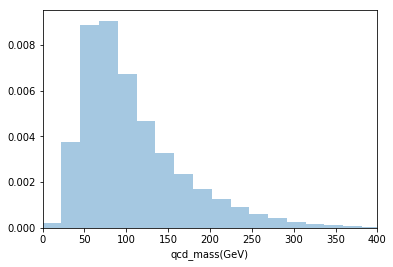

In [105]:
sns.distplot(qcd_mass, kde = False, norm_hist = True)
plt.xlim(0, 400)
plt.xlabel("qcd_mass(GeV)")

In [106]:
ttbar_mass = f_ttbar["objects/jets/obs"][:,0]
ttbar_mass = ttbar_mass[:,3]

In [107]:
ttbar_mass.shape

(320124,)

Text(0.5, 0, 'mass(GeV)')

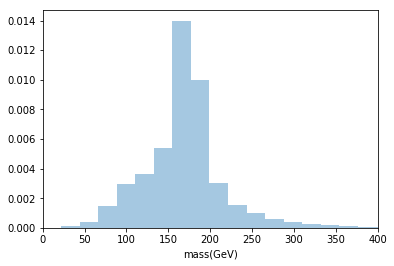

In [108]:
sns.distplot(ttbar_mass, kde = False, norm_hist = True)
plt.xlim(0, 400)
plt.xlabel("mass(GeV)")

In [109]:
Zboson_mass = f_Zboson["objects/jets/obs"][:,0]
Zboson_mass = Zboson_mass[:,3]
Zboson_mass.shape

(97579,)

(0, 300)

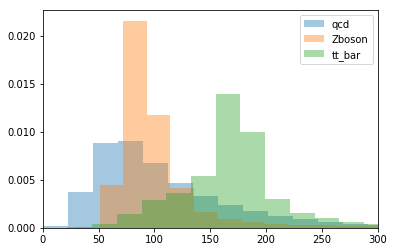

In [110]:
sns.distplot(qcd_mass, kde = False, norm_hist = True, label = "qcd")
sns.distplot(Zboson_mass, kde = False, norm_hist = True, label = "Zboson")
sns.distplot(ttbar_mass, kde = False, norm_hist = True, label = "tt_bar")
plt.legend()
plt.xlim(0, 300)

In [111]:
val_jets_mass = qcd_mass[2*lentraindata:3*lentraindata]
test_jets_mass = ttbar_mass[:lentraindata]

In [112]:
val_jets_mass.shape

(97579,)

In [113]:
def etaphipte_to_pxpypze(jet):
    v = TLorentzVector()
    v.SetPtEtaPhiE(*jet[[2,0,1,3]])
    return (v.Px,v.Py,v.Pz,v.E)

def m_from_pxpypze(jet):
    v = TLorentzVector()
    v.SetPxPyPzE(*jet)
    return v.M()

def pt_from_pxpypze(jet):
    v = TLorentzVector()
    v.SetPxPyPzE(*jet)
    return v.Pt

In [114]:
def _jetmass_from_const(jetconst,pxpypze=False):
    if pxpypze == False:
        jets_xyz = np.apply_along_axis(etaphipte_to_pxpypze,2,jetconst)
    else:
        jets_xyz = jetconst
    print("jets_xyz:",jets_xyz.shape)
    jets_m = np.apply_along_axis(m_from_pxpypze,-1,np.sum(jets_xyz,axis=1))
    return jets_m

In [115]:
train_true_m = _jetmass_from_const(train_jets,pxpypze=True)
train_jets_norm = train_jets / train_jet_pt[::,np.newaxis,np.newaxis]

test_true_m = _jetmass_from_const(test_jets,pxpypze=True)
test_jets_norm = test_jets / test_jet_pt[::,np.newaxis,np.newaxis]

outlier_true_m = _jetmass_from_const(outlier_jets,pxpypze=True)
outlier_jets_norm = outlier_jets / outlier_jet_pt[::,np.newaxis,np.newaxis]

val_true_m = _jetmass_from_const(val_jets,pxpypze=True)
val_jets_norm = val_jets / val_jet_pt[::,np.newaxis,np.newaxis]

jets_xyz: (195158, 20, 4)
jets_xyz: (97579, 20, 4)
jets_xyz: (97579, 20, 4)
jets_xyz: (97579, 20, 4)


In [129]:
val_jet_pt.shape

(97579,)

In [130]:
val_jets.shape

(97579, 20, 4)

In [116]:
train_true_m.shape

(195158,)

(0, 300)

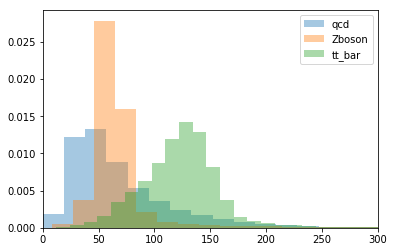

In [117]:
sns.distplot(train_true_m, kde = False, norm_hist = True, label = "qcd")
sns.distplot(outlier_true_m, kde = False, norm_hist = True, label = "Zboson")
sns.distplot(test_true_m, kde = False, norm_hist = True, label = "tt_bar")
plt.legend()
plt.xlim(0, 300)

## Functions to plot

In [118]:
def jetPlot(jets,selection=None,label=None,axis=None,Eplot=False):
    '''Plot the 2D jet image of the jet in eta-phi space.
    By default, constituent pT will be used for the z-axis.
    Inputs:
        jets: collection of jets in the form [njet,nconstituents,(eta,phi,...,pT,eta)]
    Optional:
        selection: any additional jet based selection
        label: jet label for the axis title
        axis: can pass a matplotlib axis instead of creating a new axis
        Eplot: Use constituent energy on the z-axis instead of pT
    Returns:
        matplotlib axis
    '''

    eta = jets[:,:,0]
    phi = jets[:,:,1]
    njet = eta.shape[0]
    nclusters = eta.shape[1]
    z = jets[:,:,3] if Eplot else jets[:,:,2]

    if selection is not None:
        z = z.ravel()*np.repeat(selection,nclusters)
    else:
        z = z.ravel()

    if axis is None:
        fig,axis = plt.subplots(1,1)
    h = axis.hist2d(eta.ravel(),phi.ravel(),weights=z / njet,bins=(np.arange(-1.525,1.525,0.05),np.arange(-1.525,1.525,0.05)), norm=LogNorm(),cmap='viridis',vmin=1e-8,vmax=1.0)
    plt.colorbar(h[3], ax=axis)
    axis.set_xlabel("$\Delta\eta$",horizontalalignment='right',x=1.0)
    axis.set_ylabel("$\Delta\phi$",verticalalignment='top',y=1.0)
    axis.set_title(label)
    return axis

def _jet_image_plots(val,test,val_label,test_label):#tputpath,name,pxpypze=False):
    fig,axes = plt.subplots(nrows=1,ncols=2)
    fig.set_size_inches(12, 5)
    
    val2 = val[:,:,[-1,0,1,2]]
    val2 = ExyzToEtaPhiPtE(val2)

    jetPlot(val2,label=val_label,axis=axes[0])
    del val2
    test2 = test[:,:,[-1,0,1,2]]
    test2 = ExyzToEtaPhiPtE(test2)
    jetPlot(test2,label=test_label,axis=axes[1])
    del test2

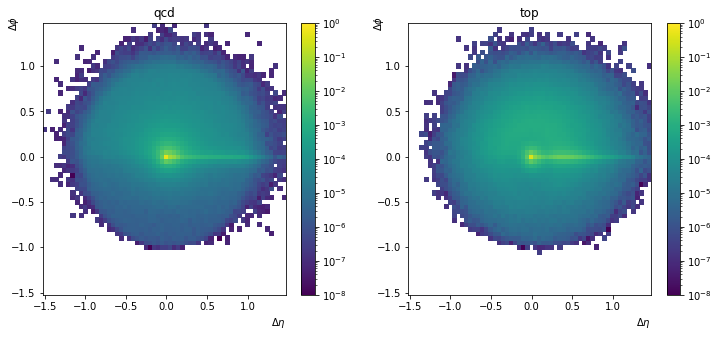

In [119]:
train='qcd'# 'top'
outlier = 'Zp3300_S400A80'
test = 'top'

_jet_image_plots(train_jets_norm,test_jets_norm,
             train,test)

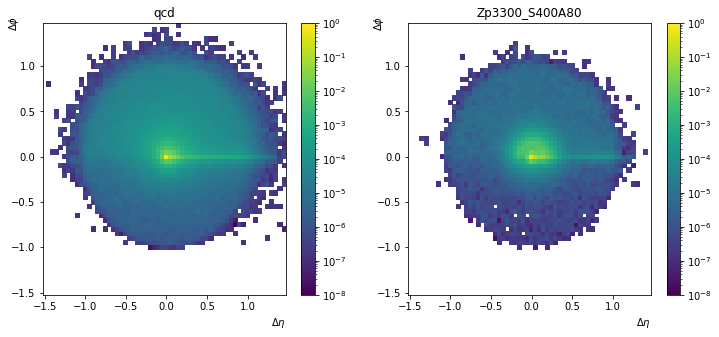

In [120]:
_jet_image_plots(val_jets_norm,outlier_jets_norm,
                 train,outlier)

In [121]:
def transform_set(x_values,transformers):
    return np.ma.masked_where(x_values.mask,
                              np.dstack([trans.transform(x_values[:,:,i].reshape(-1,1))
                                                                        .reshape(*x_values.shape[:2],1)\
                              for i,trans in enumerate(transformers)]))

def untransform_set(x_values,transformers):
    return np.dstack([trans.inverse_transform(x_values[:,:,i].reshape(-1,1))
                      .reshape(*x_values.shape[:2],1)\
                      for i,trans in enumerate(transformers)])

In [122]:
transformers = [RobustScaler().fit(train_jets_norm[:,:,i][~train_jets.mask[:,:,i]].reshape(-1,1)) for i in range(train_jets.shape[-1])] 

In [123]:
train_jets_t = transform_set(train_jets_norm,transformers)
train_jets_t  = train_jets_t.reshape(-1,20*4)
outlier_jets_t = transform_set(outlier_jets_norm,transformers)
outlier_jets_t  = outlier_jets_t.reshape(-1,20*4)
test_jets_t = transform_set(test_jets_norm,transformers)
test_jets_t  = test_jets_t.reshape(-1,20*4)
val_jets_t = transform_set(val_jets_norm,transformers)
val_jets_t  = val_jets_t.reshape(-1,20*4)

In [126]:
train_jets_t.shape

(195158, 80)

## Grouping data for training and testing

In [127]:
#training dataset
train_anchor = train_jets_t[:lentraindata]
train_positive = train_jets_t[lentraindata:2*lentraindata]
train_outlier = outlier_jets_t
train_vanillaVAE = np.concatenate((train_anchor,train_positive),axis = 0)
print("Shape of train_anchor: ",train_anchor.shape)
print("Shape of train_positive: ",train_positive.shape)
print("Shape of train_outlier: ",train_outlier.shape)
print("Shape of train_vanillaVAE: ",train_vanillaVAE.shape)

Shape of train_anchor:  (97579, 80)
Shape of train_positive:  (97579, 80)
Shape of train_outlier:  (97579, 80)
Shape of train_vanillaVAE:  (195158, 80)


In [128]:
test_jets_mass.shape

(97579,)

In [159]:
#testing dataset
test_qcd_top = np.concatenate((val_jets_t,test_jets_t), axis = 0)
test_qcd_top_pt = np.concatenate((val_jet_pt,test_jet_pt), axis = 0)
test_qcd_top_mass = np.concatenate((val_jets_mass,test_jets_mass), axis = 0)
test_qcd_top_mass_const = np.concatenate((val_true_m,test_true_m), axis = 0)
test_y = np.concatenate((np.zeros(len(val_jets_t)), np.ones(len(test_jets_t))), axis=0)
# Shuffling test data
rng = check_random_state(1)
indices_test = rng.permutation(len(test_qcd_top))
test_qcd_top_shuffled = test_qcd_top[indices_test]
test_qcd_top_mass_shuffled = test_qcd_top_mass[indices_test]
test_qcd_top_mass_const_shuffled = test_qcd_top_mass_const[indices_test]
test_qcd_top_pt_shuffled = test_qcd_top_pt[indices_test]
test_y_shuffled = test_y[indices_test]
print("Shape of test_qcd_top_shuffled: ",test_qcd_top_shuffled.shape)
print("Shape of test_qcd_top_mass_shuffled: ",test_qcd_top_mass_shuffled.shape)
print("Shape of test_y_shuffled: ",test_y_shuffled.shape)

Shape of test_qcd_top_shuffled:  (195158, 80)
Shape of test_qcd_top_mass_shuffled:  (195158,)
Shape of test_y_shuffled:  (195158,)


## Encoder and Decoder Architecture

In [132]:
# Defining Sampling function
encoding_dim = 16
def sampling(args):
    mu, sigma = args
    batch     = tf.shape(mu)[0]
    dim       = tf.shape(mu)[1]
    eps       = tf.keras.backend.random_normal(shape=(batch, dim))
    return mu + tf.exp(sigma / 2) * eps

In [133]:
# Defining Encoder
class Encoder(Model):
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.layer_1 = Dense(128, activation="relu")
        self.layer_2 = Dense(64, activation="relu")
        self.layer_3 = Dense(32, activation="relu")
    
    def call(self,inputs):
        x = self.layer_1(inputs)
        x = self.layer_2(x)
        x = self.layer_3(x)
        self.mean = Dense(encoding_dim, name="z_mean")(x)
        self.log_var = Dense(encoding_dim, name="z_log_var")(x)
        self.z = Lambda(sampling, output_shape=(encoding_dim,), name='z')([self.mean, self.log_var])
        return self.mean, self.log_var,self.z

In [134]:
# Defining Decoder
class Decoder(Model):
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.layer_1 = Dense(32, activation="relu")
        self.layer_2 = Dense(64, activation="relu")
        self.layer_3 = Dense(128, activation="relu")
        self.layer_4 = Dense(80, activation="linear")
    def call(self,inputs):
        x = self.layer_1(inputs)
        x = self.layer_2(x)
        x = self.layer_3(x)
        output = self.layer_4(x)
        return output

In [135]:
# kl divergence loss
# https://keras.io/examples/generative/vae/

def kl_reconstruction_loss(x, recon_x, mu, log_var):
    reco_loss = tf.reduce_sum(tf.pow(x - recon_x,2), axis= -1)
    kl_loss = 1 + log_var - tf.square(mu) - tf.exp(log_var)
    kl_loss = tf.reduce_sum(kl_loss, axis= -1)
    kl_loss *= -0.5
    return tf.reduce_mean(0.2*reco_loss + 0.4*kl_loss)

## Vanilla VAE training

In [136]:
encoder = Encoder()
decoder = Decoder()
optimizer = tf.keras.optimizers.Adam()
batch_size = 600
epochs = 30
epochs_train_losses = []
for epoch in range(epochs):
    print('Start of epoch',epoch)
    losses = []
    triplet_losses = []
    for i in range(0, len(train_vanillaVAE)//batch_size):
        qcd = train_vanillaVAE [i*batch_size:min(len(train_vanillaVAE),(i+1)*batch_size)]
        
        with tf.GradientTape() as tape:
            mean_qcd,log_var_qcd,latent_qcd = encoder(qcd)
            
            reconstructed_qcd = decoder(latent_qcd)
            
            loss = kl_reconstruction_loss(qcd, reconstructed_qcd, mean_qcd, log_var_qcd)
            
            tvae_weights = encoder.trainable_weights + decoder.trainable_weights
        gradients = tape.gradient(loss, tvae_weights)
        # Calculate gradients
        optimizer.apply_gradients(zip(gradients, tvae_weights))
        losses.append(loss)
    
    epochs_train_losses.append(tf.reduce_mean(losses))
    
    print("epochs_train_losses:", epochs_train_losses[epoch])

Start of epoch 0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

epochs_train_losses: tf.Tensor(91.219765, shape=(), dtype=float32)
Start of epoch 1
epochs_train_losses: tf.Tensor(77.29814, shape=(), dtype=float32)
Start of epoch 2
epochs_train_losses: tf.Tensor(74.27874, shape=(), dtype=float32)
Start of epoch 3
epochs_train_losses: tf.Tensor(71.915306, shape=(), dtype=float32)
Start of epoch 4
epochs_train_losses: tf.Tensor(71.02121, shape=(), dtype=float32)
Start of epoch 5
epochs_train_losses: tf.Tensor(70.6708, shape=(), dtype=float32)
Start of 

<function matplotlib.pyplot.show(*args, **kw)>

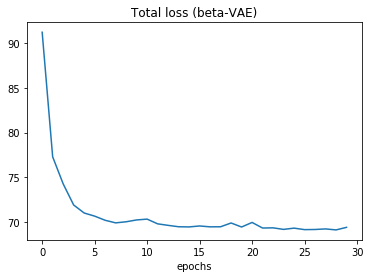

In [137]:
plt.plot(epochs_train_losses)
plt.title("Total loss (beta-VAE)")
plt.xlabel("epochs")
plt.show

In [104]:
val_jets_mean, val_jets_var,val_jets_latent = encoder(val_jets_t)#qcd
outlier_test_mean, outlier_test_var, outlier_test_latent = encoder(test_jets_t)#top

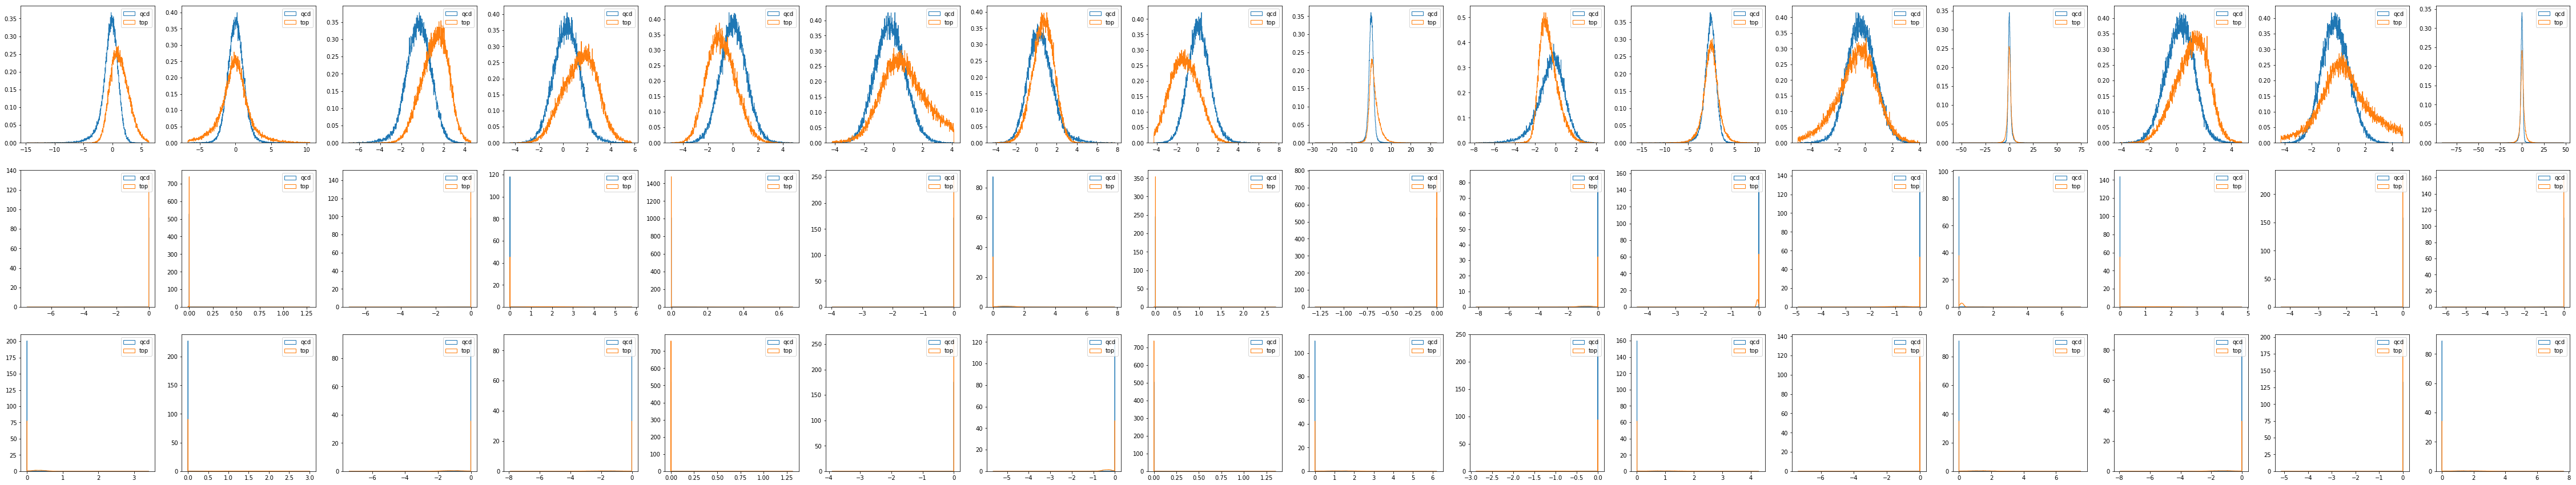

In [105]:
train = 'qcd'
test = 'top'
fig,axes = plt.subplots(ncols=16,nrows=3)
fig.set_size_inches(5*16,15)
for d in range(16):
    _,bins,_=axes[0][d].hist(val_jets_latent[:,d],bins=1000,histtype='step',density=True,label=train)
    axes[0][d].hist(outlier_test_latent[:,d],bins=bins,histtype='step',density=True,label=test)
    _,bins,_=axes[1][d].hist(val_jets_mean[:,d],bins=1000,histtype='step',density=True,label=train)
    axes[1][d].hist(outlier_test_mean[:,d],bins=bins,histtype='step',density=True,label=test)
    _,bins,_=axes[2][d].hist(val_jets_var[:,d],bins=1000,histtype='step',density=True,label=train)
    axes[2][d].hist(outlier_test_var[:,d],bins=bins,histtype='step',density=True,label=test)
    for i in range(3):
        axes[i][d].legend()

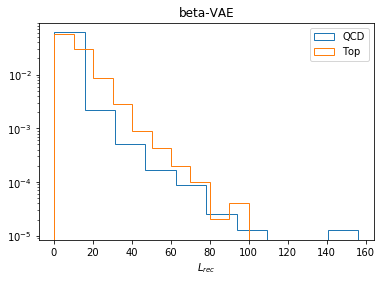

In [138]:
_, _, test_latent = encoder(test_qcd_top_shuffled)
test_decoded = decoder(test_latent)
predict_loss= np.mean(np.power(test_qcd_top_shuffled - test_decoded, 2), axis=1)

l_rec_0=[]
l_rec_1=[]
l_mass_0=[]
l_mass_1=[]

for i in range(10000):
    if test_y_shuffled[i]==0:
        l_rec_0.append(predict_loss[i])
    else:
        l_rec_1.append(predict_loss[i])

for i in range(10000):
    if test_y_shuffled[i]==0:
        l_mass_0.append(test_qcd_top_mass_shuffled[i])
    else:
        l_mass_1.append(test_qcd_top_mass_shuffled[i])        
        
l_rec_0=np.array(l_rec_0)
l_rec_1=np.array(l_rec_1)

l_mass_0=np.array(l_mass_0)
l_mass_1=np.array(l_mass_1)

plt.hist(l_rec_0, histtype="step", label='QCD',density=True)
plt.hist(l_rec_1, histtype='step', label='Top',density=True)
plt.legend(loc='best')
plt.yscale("log")
plt.title('beta-VAE')
plt.xlabel('$L_{rec}$')
plt.show()

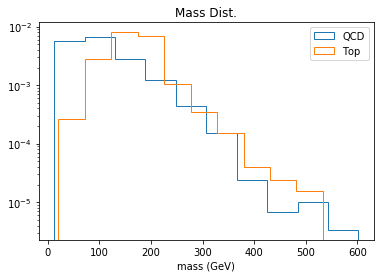

In [139]:
plt.hist(l_mass_0, histtype="step", label='QCD',density=True)
plt.hist(l_mass_1, histtype='step', label='Top',density=True)
plt.legend(loc='best')
plt.yscale("log")
plt.title('Mass Dist.')
plt.xlabel('mass (GeV)')
plt.show()

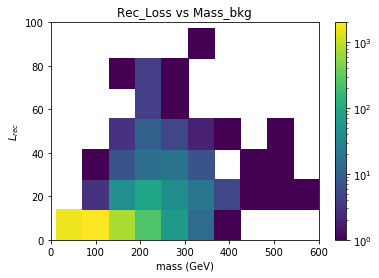

In [60]:
# Creating plot
#plt.hist2d(l_mass_0, l_rec_0, bins=10,)
#plt.title("Simple 2D Histogram")
  
# show plot
#plt.show()

fig, ax = plt.subplots()
h = ax.hist2d(l_mass_0, l_rec_0, bins=10, norm=LogNorm())
fig.colorbar(h[3], ax=ax)
plt.title("Rec_Loss vs Mass_bkg")
plt.xlabel("mass (GeV)")
plt.ylabel('$L_{rec}$')
plt.ylim(0,100)
plt.xlim(0,600)
# show plot
plt.show()

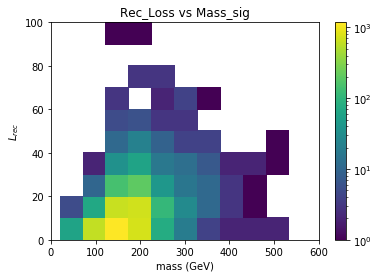

In [61]:
fig, ax = plt.subplots()
h = ax.hist2d(l_mass_1, l_rec_1, bins=10, norm=LogNorm())
fig.colorbar(h[3], ax=ax)
plt.title("Rec_Loss vs Mass_sig")
plt.xlabel("mass (GeV)")
plt.ylabel('$L_{rec}$')
plt.ylim(0,100)
plt.xlim(0,600)
# show plot
plt.show()

/lcg/storage15/software64/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
No handles with labels found to put in legend.


roc_auc = 0.8512749433993437


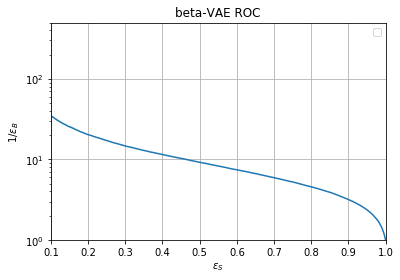

In [140]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thrs = roc_curve(test_y_shuffled, predict_loss)
print("roc_auc =", roc_auc_score(test_y_shuffled, predict_loss))
#plt.plot(fpr, tpr, label="%s" % filename)
plt.plot(tpr, 1. / fpr, label="")

plt.xlim(0.1, 1.0)
plt.ylim(1, 500)
plt.yscale("log")
plt.title('beta-VAE ROC')
plt.grid()
plt.xlabel("$\epsilon_S$")
plt.ylabel("$1/\epsilon_B$")
plt.legend(loc="best")
plt.show()

In [160]:
# Decoded mass
test_decoded = np.array(test_decoded)
test_reco_t  = test_decoded.reshape(-1,20,4)
test_reco_t = untransform_set(test_reco_t,transformers)
test_reco_t = test_reco_t*test_qcd_top_pt_shuffled[::,np.newaxis,np.newaxis]
test_mass_reco = _jetmass_from_const(test_reco_t,pxpypze=True)
predict_mass_loss= np.power(test_qcd_top_mass_const_shuffled - test_mass_reco, 2)

jets_xyz: (195158, 20, 4)


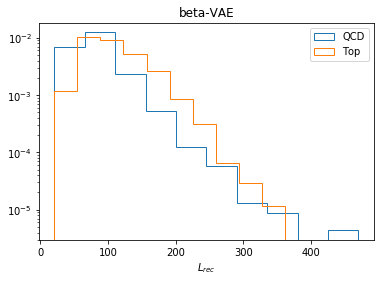

In [158]:
l_const_mass_0=[]
l_const_mass_1=[]

l_const_reco_mass_0=[]
l_const_reco_mass_1=[]

for i in range(10000):
    if test_y_shuffled[i]==0:
        l_const_mass_0.append(test_qcd_top_mass_const_shuffled[i])
    else:
        l_const_mass_1.append(test_qcd_top_mass_const_shuffled[i])        
        
for i in range(10000):
    if test_y_shuffled[i]==0:
        l_const_reco_mass_0.append(test_mass_reco[i])
    else:
        l_const_reco_mass_1.append(test_mass_reco[i])  

l_const_mass_0=np.array(l_const_mass_0)
l_const_mass_1=np.array(l_const_mass_1)

l_const_reco_mass_0=np.array(l_const_reco_mass_0)
l_const_reco_mass_1=np.array(l_const_reco_mass_1)

#plt.hist(l_const_mass_0, histtype="step", label='QCD',density=True)
#plt.hist(l_const_mass_1, histtype='step', label='Top',density=True)
plt.hist(l_const_reco_mass_0, histtype="step", label='QCD',density=True)
plt.hist(l_const_reco_mass_1, histtype='step', label='Top',density=True)
plt.legend(loc='best')
plt.yscale("log")
plt.title('beta-VAE')
plt.xlabel('$L_{rec}$')
plt.show()

/lcg/storage15/software64/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
No handles with labels found to put in legend.


roc_auc = 0.525590544163742


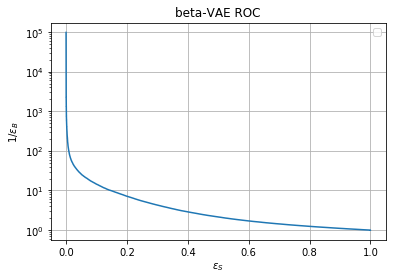

In [157]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thrs = roc_curve(test_y_shuffled, predict_mass_loss)
print("roc_auc =", roc_auc_score(test_y_shuffled, predict_mass_loss))
#plt.plot(fpr, tpr, label="%s" % filename)
plt.plot(tpr, 1. / fpr, label="")

#plt.xlim(0.1, 1.0)
#plt.ylim(1, 500)
plt.yscale("log")
plt.title('beta-VAE ROC')
plt.grid()
plt.xlabel("$\epsilon_S$")
plt.ylabel("$1/\epsilon_B$")
plt.legend(loc="best")
plt.show()

## Triplet  VAE (TVAE)

In [63]:
encoder = Encoder()
decoder = Decoder()
alpha = 0.3
optimizer = tf.keras.optimizers.Adam()
epochs = 30
batch_size = 600
epochs_train_losses = []
epochs_triplet_losses = []
epochs_reco_losses = []

for epoch in range(epochs):
    print('Start of epoch',epoch)
    losses = []
    triplet_losses = []
    for i in range(0, len(train_anchor)//batch_size):
        anc = train_anchor[i*batch_size:min(len(train_anchor),(i+1)*batch_size)]
        pos = train_positive[i*batch_size:min(len(train_positive),(i+1)*batch_size)]
        neg = train_outlier[i*batch_size:min(len(train_outlier),(i+1)*batch_size)]
        anc_pos = np.concatenate((anc,pos), axis = 0)
        
        with tf.GradientTape() as tape:
            mean_anc,log_var_anc,latent_anc = encoder(anc)
            mean_pos,log_var_pos,latent_pos = encoder(pos)
            mean_neg,log_var_neg,latent_neg = encoder(neg)
            latent_anc_pos = np.concatenate((latent_anc,latent_pos), axis = 0)
            mean_anc_pos = np.concatenate((mean_anc,mean_pos), axis = 0)
            log_var_anc_pos = np.concatenate((log_var_anc,log_var_pos), axis = 0)
            dp = tf.reduce_mean(tf.reduce_sum(tf.square(mean_anc - mean_pos), axis = -1))
            dn = tf.reduce_mean(tf.reduce_sum(tf.square(mean_anc - mean_neg), axis = -1))
            triplet_loss = tf.maximum(dp-dn+alpha, 0.)
            reconstructed_anc_pos = decoder(latent_anc_pos)
            reconstruction_loss = kl_reconstruction_loss(anc_pos, reconstructed_anc_pos, mean_anc_pos, log_var_anc_pos)
            loss = 0.4*triplet_loss
            loss+= reconstruction_loss
            tvae_weights = encoder.trainable_weights + decoder.trainable_weights
        gradients = tape.gradient(loss, tvae_weights)
        # Calculate gradients
        optimizer.apply_gradients(zip(gradients, tvae_weights))
        losses.append(loss)
        triplet_losses.append(triplet_loss)

    epochs_train_losses.append(tf.reduce_mean(losses))
    epochs_triplet_losses.append(tf.reduce_mean(triplet_losses))
    print("epochs_train_losses:", epochs_train_losses[epoch], "epochs_triplet_losses:", epochs_triplet_losses[epoch])

Start of epoch 0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

epochs_train_losses: tf.Tensor(93.8976, shape=(), dtype=float32) epochs_triplet_losses: tf.Tensor(0.95078814, shape=(), dtype=float32)
Start of epoch 1
epochs_train_losses: tf.Tensor(84.60952, shape=(), dtype=float32) epochs_triplet_losses: tf.Tensor(0.016739542, shape=(), dtype=float32)
Start of epoch 2
epochs_train_losses: tf.Tensor(84.094604, shape=(), dtype=float32) epochs_triplet_losses: tf.Tensor(0.006987587, shape=(), dtype=float32)
Start of epoch 3
epochs_train_losses: tf.Tensor

<function matplotlib.pyplot.show(*args, **kw)>

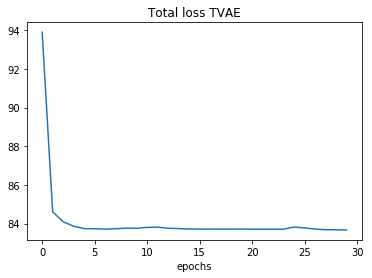

In [65]:
plt.plot(epochs_train_losses)
plt.title("Total loss TVAE")
plt.xlabel("epochs")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

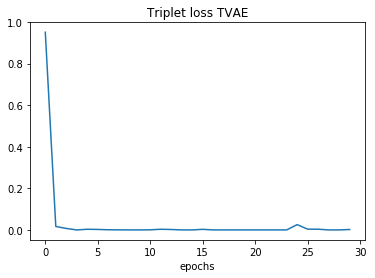

In [66]:
plt.plot(epochs_triplet_losses)
plt.title("Triplet loss TVAE")
plt.xlabel("epochs")
plt.show

In [123]:
val_jets_mean, val_jets_var,val_jets_latent = encoder(val_jets_t)#qcd
outlier_test_mean, outlier_test_var, outlier_test_latent = encoder(test_jets_t)#top

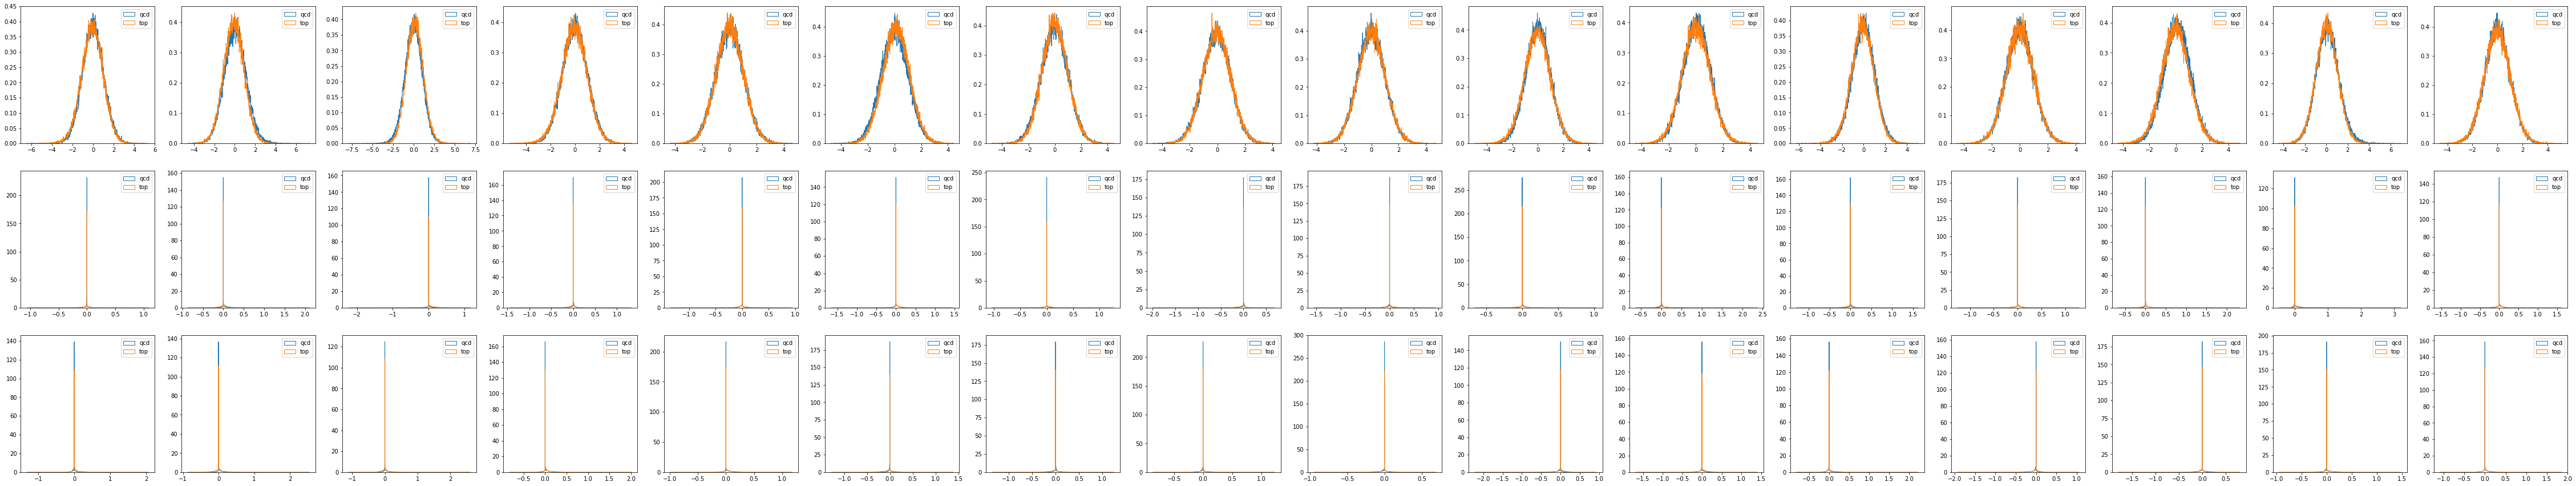

In [124]:
train = 'qcd'
test = 'top'
fig,axes = plt.subplots(ncols=16,nrows=3)
fig.set_size_inches(5*16,15)
for d in range(16):
    _,bins,_=axes[0][d].hist(val_jets_latent[:,d],bins=1000,histtype='step',density=True,label=train)
    axes[0][d].hist(outlier_test_latent[:,d],bins=bins,histtype='step',density=True,label=test)
    _,bins,_=axes[1][d].hist(val_jets_mean[:,d],bins=1000,histtype='step',density=True,label=train)
    axes[1][d].hist(outlier_test_mean[:,d],bins=bins,histtype='step',density=True,label=test)
    _,bins,_=axes[2][d].hist(val_jets_var[:,d],bins=1000,histtype='step',density=True,label=train)
    axes[2][d].hist(outlier_test_var[:,d],bins=bins,histtype='step',density=True,label=test)
    for i in range(3):
        axes[i][d].legend()

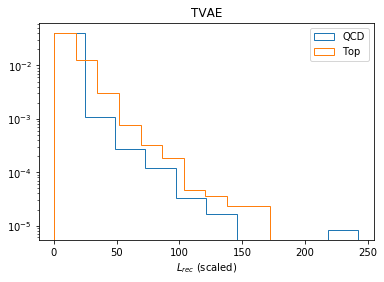

In [67]:
_, _, test_latent = encoder(test_qcd_top_shuffled)
test_decoded = decoder(test_latent)
predict_loss= np.mean(np.power(test_qcd_top_shuffled - test_decoded, 2), axis=1)
l_rec_0=[]
l_rec_1=[]
l_mass_0=[]
l_mass_1=[]

for i in range(10000):
    if test_y_shuffled[i]==0:
        l_rec_0.append(predict_loss[i])
    else:
        l_rec_1.append(predict_loss[i])
        
for i in range(10000):
    if test_y_shuffled[i]==0:
        l_mass_0.append(test_qcd_top_mass_shuffled[i])
    else:
        l_mass_1.append(test_qcd_top_mass_shuffled[i])  

l_rec_0=np.array(l_rec_0)
l_rec_1=np.array(l_rec_1)

l_mass_0=np.array(l_mass_0)
l_mass_1=np.array(l_mass_1)

plt.hist(l_rec_0, histtype="step", label='QCD',density=True)
plt.hist(l_rec_1, histtype='step', label='Top',density=True)
plt.legend(loc='best')
plt.yscale("log")
plt.title('TVAE')
plt.xlabel('$L_{rec}$ (scaled)')
plt.show()

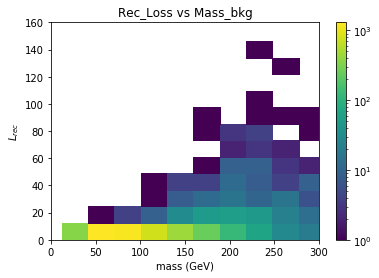

In [74]:
# Creating plot
#plt.hist2d(l_mass_0, l_rec_0, bins=10,)
#plt.title("Simple 2D Histogram")
  
# show plot
#plt.show()

fig, ax = plt.subplots()
h = ax.hist2d(l_mass_0, l_rec_0, bins=20, norm=LogNorm())
fig.colorbar(h[3], ax=ax)
plt.ylim(0,160)
plt.title("Rec_Loss vs Mass_bkg")
plt.xlabel("mass (GeV)")
plt.ylabel('$L_{rec}$')
plt.xlim(0,300)
# show plot
plt.show()

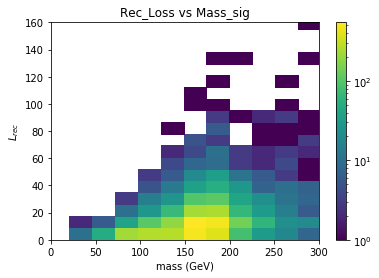

In [75]:
fig, ax = plt.subplots()
h = ax.hist2d(l_mass_1, l_rec_1, bins=20, norm=LogNorm())
fig.colorbar(h[3], ax=ax)
plt.ylim(0,160)
plt.title("Rec_Loss vs Mass_sig")
plt.xlabel("mass (GeV)")
plt.ylabel('$L_{rec}$')
plt.xlim(0,300)
# show plot
plt.show()

/lcg/storage15/software64/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
No handles with labels found to put in legend.


roc_auc = 0.8595003601640946


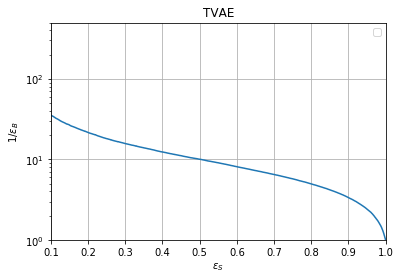

In [73]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thrs = roc_curve(test_y_shuffled, predict_loss)
print("roc_auc =", roc_auc_score(test_y_shuffled, predict_loss))
#plt.plot(fpr, tpr, label="%s" % filename)
plt.plot(tpr, 1. / fpr, label="")

plt.xlim(0.1, 1.0)
plt.ylim(1, 500)
plt.yscale("log")
plt.title('TVAE')
plt.grid()
plt.xlabel("$\epsilon_S$")
plt.ylabel("$1/\epsilon_B$")
plt.legend(loc="best")
plt.show()